# VISUALIZE OUTPUT FROM REGISTRATION

- change `DATA_PTH` to point to your main processing output folder
- change `REG_DIR` to point to the directory where registration output is stored. tifs should be stored there as `0000.tif`

`conda activate imgpro`

In [38]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt
import scipy.ndimage as ndi

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

fixed = '0100' # 20251028 worm001
# fixed = '0002' # 20251121 worm002
# fixed = '1080'

mov = '0810'

chan = 1 # 0,gfp 1,rfp

DATA_PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'

# REG_DIR = 'registered_elastic'
REG_DIR = 'registered_wholistic_smooth-0.200_patch-7'

FIXED_PTH = os.path.join(DATA_PTH,'warped',f'{fixed}.tif')
REG_PTH = os.path.join(DATA_PTH,REG_DIR,f'{mov}.tif')
WARP_PTH = os.path.join(DATA_PTH,'warped',f'{mov}.tif')

if 'wholistic' in REG_DIR:
    zoom = 1 
else:
    zoom = 1 #1/3 # 3
# fixed = ndi.zoom(tifffile.imread(FIXED_PTH)[:,chan,:,:], zoom=(zoom,1,1)) # just the red channel (ZHW)
# move = tifffile.imread(REG_PTH)[:,chan,:,:] # just the red channel (ZHW)
# warped = ndi.zoom(tifffile.imread(WARP_PTH)[:,chan,:,:], zoom=(zoom,1,1)) # just the red channel (ZHW)

fixed = tifffile.imread(FIXED_PTH)[:,chan,:,:] # just the red channel (ZHW)
reg = ndi.zoom(tifffile.imread(REG_PTH)[:,chan,:,:], zoom=(zoom,1,1)) # just the red channel (ZHW)
warped = tifffile.imread(WARP_PTH)[:,chan,:,:] # just the red channel (ZHW)

if 'gfp+1' in REG_DIR:
    reg = np.concatenate((reg, np.zeros((1,200,500))), axis=0)

reg_stack = np.concatenate((fixed[np.newaxis,:,:,:],reg[np.newaxis,:,:,:]), axis=0) # CZHW

warp_stack = np.concatenate((fixed[np.newaxis,:,:,:],warped[np.newaxis,:,:,:]), axis=0)

CREATE PANEL

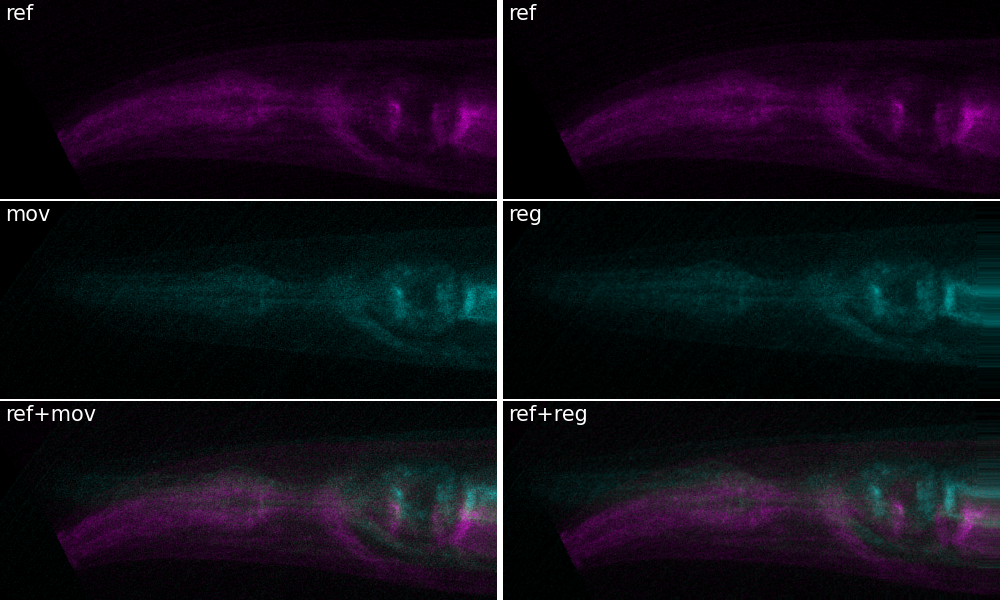

In [39]:
%matplotlib widget

plt.close('all')

mn = 0
mx = 600
# mx = 100
fs = 5

cmap_ref = 'magenta'
cmap_mov_reg = 'cyan'

anim1 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim2 = Microanim(
    data=warped[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='mov')
anim3 = Microanim(
    data=warp_stack, cmaps=[cmap_ref, cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+mov')


anim4 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim5 = Microanim(
    data=reg[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='reg')
anim6 = Microanim(
    data=reg_stack, cmaps=[cmap_ref,cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+reg')

plt.close('all')

animpanel = Microanimpanel(rows=3, cols=2,)
animpanel.add_element(pos=[0,0], microanim=anim1)
animpanel.add_element(pos=[1,0], microanim=anim2)
animpanel.add_element(pos=[2,0], microanim=anim3)

animpanel.add_element(pos=[0,1], microanim=anim4)
animpanel.add_element(pos=[1,1], microanim=anim5)
animpanel.add_element(pos=[2,1], microanim=anim6)

animpanel.ui



SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'
OUT_FN = ''

animpanel.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=6)

### LAPLACIAN DEMO

laplace + variance as a measure of image sharpness

Variance of Laplacian: blurry(z=2) = 430.28
Variance of Laplacian: sharp (z=23) = 1112.76


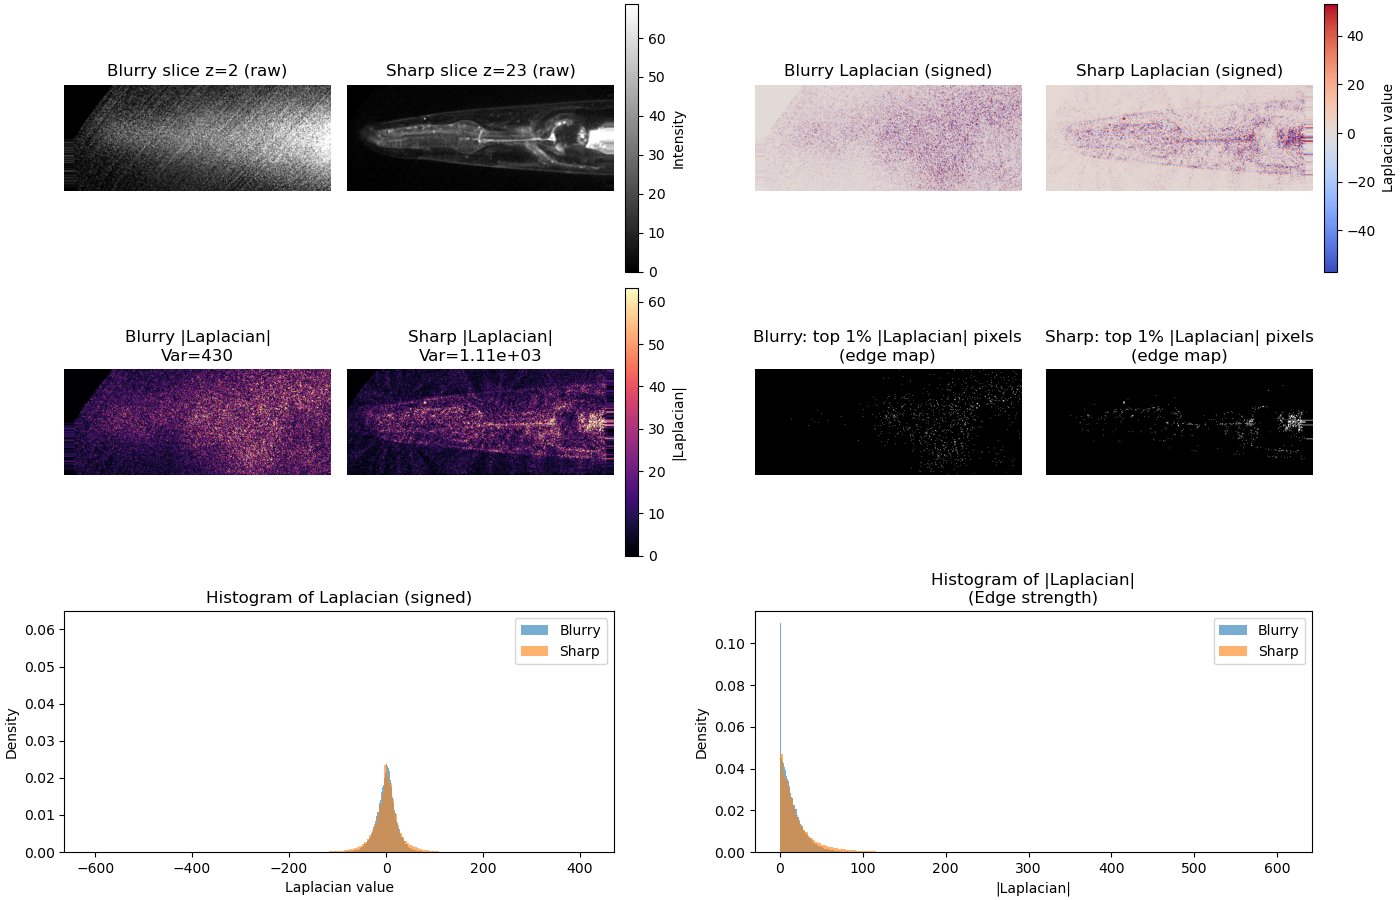

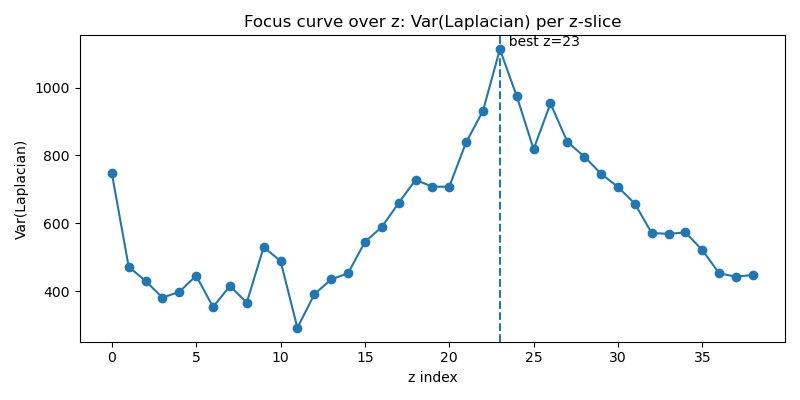

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import laplace, gaussian_filter

# -----------------------------
# Educational visualization code
# -----------------------------
# Assumes you already have `reg` as a numpy array of shape (Z, H, W) or (some_index, H, W).
# In your snippet you used reg[z, :, :], so we treat axis 0 as Z.

def compute_laplacian(image, sigma_preblur=0.0):
    """
    Compute Laplacian of an image (optionally after light Gaussian pre-blur to suppress noise).
    Returns the Laplacian image (float64).
    """
    img = image.astype(np.float64)
    if sigma_preblur and sigma_preblur > 0:
        img = gaussian_filter(img, sigma=sigma_preblur)
    return laplace(img)

def laplacian_variance(image, sigma_preblur=0.0):
    """
    Variance of Laplacian as a focus/sharpness metric.
    """
    L = compute_laplacian(image, sigma_preblur=sigma_preblur)
    return float(np.var(L))

def robust_imshow(ax, img, title="", cmap=None, robust=True):
    """
    Display an image with robust contrast scaling (percentile clipping).
    """
    if robust:
        vmin, vmax = np.percentile(img, [1, 99])
    else:
        vmin, vmax = None, None
    im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis("off")
    return im

def compare_slices(reg, z_blurry=2, z_sharp=25, sigma_preblur=0.0, take_abs=True):
    """
    Visualize blurry vs sharp z-slices with:
      - raw images
      - Laplacian images
      - |Laplacian|
      - histograms of Laplacian values
      - focus metric printed and shown in titles
    """
    blurry = reg[z_blurry, :, :]
    sharp  = reg[z_sharp, :, :]

    L_blur = compute_laplacian(blurry, sigma_preblur=sigma_preblur)
    L_shrp = compute_laplacian(sharp,  sigma_preblur=sigma_preblur)

    if take_abs:
        Lb_show = np.abs(L_blur)
        Ls_show = np.abs(L_shrp)
        lap_label = "|Laplacian|"
    else:
        Lb_show = L_blur
        Ls_show = L_shrp
        lap_label = "Laplacian (signed)"

    v_blur = laplacian_variance(blurry, sigma_preblur=sigma_preblur)
    v_shrp = laplacian_variance(sharp,  sigma_preblur=sigma_preblur)

    # Figure layout
    fig = plt.figure(figsize=(14, 9), constrained_layout=True)
    gs = fig.add_gridspec(3, 4, height_ratios=[1, 1, 0.9])

    ax00 = fig.add_subplot(gs[0, 0])
    ax01 = fig.add_subplot(gs[0, 1])
    ax02 = fig.add_subplot(gs[0, 2])
    ax03 = fig.add_subplot(gs[0, 3])

    ax10 = fig.add_subplot(gs[1, 0])
    ax11 = fig.add_subplot(gs[1, 1])
    ax12 = fig.add_subplot(gs[1, 2])
    ax13 = fig.add_subplot(gs[1, 3])

    ax20 = fig.add_subplot(gs[2, 0:2])
    ax21 = fig.add_subplot(gs[2, 2:4])

    # Row 1: Raw images
    im00 = robust_imshow(ax00, blurry, title=f"Blurry slice z={z_blurry} (raw)", cmap="gray", robust=True)
    im01 = robust_imshow(ax01, sharp,  title=f"Sharp slice z={z_sharp} (raw)",  cmap="gray", robust=True)
    cbar0 = fig.colorbar(im00, ax=[ax00, ax01], fraction=0.046, pad=0.02)
    cbar0.set_label("Intensity")

    # Row 1: Laplacian (signed) shown separately (educational: positive/negative edges)
    im02 = robust_imshow(ax02, L_blur, title=f"Blurry Laplacian (signed)", cmap="coolwarm", robust=True)
    im03 = robust_imshow(ax03, L_shrp, title=f"Sharp Laplacian (signed)",  cmap="coolwarm", robust=True)
    cbar1 = fig.colorbar(im02, ax=[ax02, ax03], fraction=0.046, pad=0.02)
    cbar1.set_label("Laplacian value")

    # Row 2: |Laplacian| (edge strength) + titles include variance metric
    im10 = robust_imshow(ax10, Lb_show, title=f"Blurry {lap_label}\nVar={v_blur:.3g}", cmap="magma", robust=True)
    im11 = robust_imshow(ax11, Ls_show, title=f"Sharp {lap_label}\nVar={v_shrp:.3g}",  cmap="magma", robust=True)
    cbar2 = fig.colorbar(im10, ax=[ax10, ax11], fraction=0.046, pad=0.02)
    cbar2.set_label(lap_label)

    # Row 2: thresholded edges (simple educational demo)
    # Use a percentile threshold on |Laplacian| to show "where edges live"
    thr_blur = np.percentile(Lb_show, 99)
    thr_shrp = np.percentile(Ls_show, 99)
    edges_blur = Lb_show >= thr_blur
    edges_shrp = Ls_show >= thr_shrp

    ax12.imshow(edges_blur, cmap="gray")
    ax12.set_title(f"Blurry: top 1% {lap_label} pixels\n(edge map)")
    ax12.axis("off")

    ax13.imshow(edges_shrp, cmap="gray")
    ax13.set_title(f"Sharp: top 1% {lap_label} pixels\n(edge map)")
    ax13.axis("off")

    # Row 3: Histograms of Laplacian values
    # Sharp images should have broader tails (more extreme Laplacian responses)
    bins = 200
    ax20.hist(L_blur.ravel(), bins=bins, alpha=0.6, label="Blurry", density=True)
    ax20.hist(L_shrp.ravel(), bins=bins, alpha=0.6, label="Sharp",  density=True)
    ax20.set_title("Histogram of Laplacian (signed)")
    ax20.set_xlabel("Laplacian value")
    ax20.set_ylabel("Density")
    ax20.legend()

    ax21.hist(np.abs(L_blur).ravel(), bins=bins, alpha=0.6, label="Blurry", density=True)
    ax21.hist(np.abs(L_shrp).ravel(), bins=bins, alpha=0.6, label="Sharp",  density=True)
    ax21.set_title(f"Histogram of |Laplacian|\n(Edge strength)")
    ax21.set_xlabel("|Laplacian|")
    ax21.set_ylabel("Density")
    ax21.legend()

    # Suptitle and notes
    preblur_note = f" (pre-blur σ={sigma_preblur})" if sigma_preblur and sigma_preblur > 0 else ""
    # fig.suptitle(
    #     "Variance of Laplacian as a focus metric\n"
    #     "Sharp images have stronger high-frequency content → larger Laplacian responses → larger variance"
    #     + preblur_note,
    #     fontsize=14,
    #     y=0.98
    # )
    # plt.tight_layout(rect=[0, 0, 1, 0.95])

    print(f"Variance of Laplacian: blurry(z={z_blurry}) = {v_blur:.6g}")
    print(f"Variance of Laplacian: sharp (z={z_sharp}) = {v_shrp:.6g}")

    plt.show()


def focus_curve_over_z(reg, sigma_preblur=0.0):
    """
    Compute focus score (variance of Laplacian) over all z-slices and plot it.
    Returns scores (Z,).
    """
    Z = reg.shape[0]
    scores = np.zeros(Z, dtype=float)
    for z in range(Z):
        scores[z] = laplacian_variance(reg[z], sigma_preblur=sigma_preblur)

    plt.figure(figsize=(8, 4))
    plt.plot(np.arange(Z), scores, marker="o")
    plt.title("Focus curve over z: Var(Laplacian) per z-slice")
    plt.xlabel("z index")
    plt.ylabel("Var(Laplacian)")
    z_best = int(np.argmax(scores))
    plt.axvline(z_best, linestyle="--")
    plt.text(z_best, scores[z_best], f"  best z={z_best}", va="bottom")
    plt.tight_layout()
    plt.show()

    return scores

compare_slices(reg, z_blurry=2, z_sharp=23, sigma_preblur=0.0, take_abs=True)
scores = focus_curve_over_z(reg, sigma_preblur=0.0)


# COMPARE ELASTIX TO WHOLISTIC

- change `DATA_PTH` to point to your main processing output folder
- change `registered_elx_dir` and `registered_who_dir`

`conda activate imgpro`

In [ ]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt
import scipy.ndimage as ndi

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

fixed = '0181' # 20251028 worm001
# fixed = '0002' # 20251121 worm002

mov = '0005'

chan = 1 # 0,gfp 1,rfp

DATA_PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'
# DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

registered_elx_dir = 'registered_elastix'
registered_who_dir = 'registered_wholistic_smooth-0.200_patch-7'

FIXED_PTH = os.path.join(DATA_PTH,'warped',f'{fixed}.tif')
REG_ELX_PTH = os.path.join(DATA_PTH,registered_elx_dir,f'{mov}.tif')
REG_WHO_PTH = os.path.join(DATA_PTH,registered_who_dir,f'{mov}.tif')
WARP_PTH = os.path.join(DATA_PTH,'warped',f'{mov}.tif')

fixed = tifffile.imread(FIXED_PTH)[:,chan,:,:] # just the red channel (ZHW)
reg_elx = ndi.zoom(tifffile.imread(REG_ELX_PTH)[:,chan,:,:], zoom=(1/1,1,1))
reg_who = tifffile.imread(REG_WHO_PTH)[:,chan,:,:]
warped = tifffile.imread(WARP_PTH)[:,chan,:,:] # just the red channel (ZHW)

warp_stack = np.concatenate((fixed[np.newaxis,:,:,:],warped[np.newaxis,:,:,:]), axis=0)
elx_stack = np.concatenate((fixed[np.newaxis,:,:,:],reg_elx[np.newaxis,:,:,:]), axis=0) # CZHW
who_stack = np.concatenate((fixed[np.newaxis,:,:,:],reg_who[np.newaxis,:,:,:]), axis=0)

CREATE PANEL

In [ ]:
%matplotlib widget

plt.close('all')

mn = 0
mx = 600
# mx = 100
fs = 5

cmap_ref = 'magenta'
cmap_mov_reg = 'cyan'

anim1 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim2 = Microanim(
    data=warped[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='mov')
anim3 = Microanim(
    data=warp_stack, cmaps=[cmap_ref, cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+mov')

anim4 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim5 = Microanim(
    data=reg_elx[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='elx')
anim6 = Microanim(
    data=elx_stack, cmaps=[cmap_ref,cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+elx')

anim7 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim8 = Microanim(
    data=reg_who[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='who')
anim9 = Microanim(
    data=who_stack, cmaps=[cmap_ref,cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+who')

plt.close('all')

animpanel = Microanimpanel(rows=3, cols=3,)
animpanel.add_element(pos=[0,0], microanim=anim1)
animpanel.add_element(pos=[1,0], microanim=anim2)
animpanel.add_element(pos=[2,0], microanim=anim3)
animpanel.add_element(pos=[0,1], microanim=anim4)
animpanel.add_element(pos=[1,1], microanim=anim5)
animpanel.add_element(pos=[2,1], microanim=anim6)
animpanel.add_element(pos=[0,2], microanim=anim7)
animpanel.add_element(pos=[1,2], microanim=anim8)
animpanel.add_element(pos=[2,2], microanim=anim9)

animpanel.ui


SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'
OUT_FN = ''

animpanel.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=6)

# COMPARE ORIGNAL TO GFP+1  

- change `DATA_PTH` to point to your main processing output folder
- change `registered_dir` and `registered_gfp_1_dir`

`conda activate imgpro`

In [ ]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt
import scipy.ndimage as ndi

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

fixed = '0166' # 20251028 worm001
# fixed = '0002' # 20251121 worm002
mov = '0300'
chan = 1 # 0,gfp 1,rfp

DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

registered_dir = 'registered'
registered_gfp_1_dir = 'registered_gfp+1'

FIXED_PTH = os.path.join(DATA_PTH,'warped',f'{fixed}.tif')
REG_PTH = os.path.join(DATA_PTH,registered_dir,f'{mov}.tif')
REG_1_PTH = os.path.join(DATA_PTH,registered_gfp_1_dir,f'{mov}.tif')
WARP_PTH = os.path.join(DATA_PTH,'warped',f'{mov}.tif')

fixed = tifffile.imread(FIXED_PTH)[:,chan,:,:] # just the red channel (ZHW)
reg = tifffile.imread(REG_PTH)[:,chan,:,:]
reg_1 = tifffile.imread(REG_1_PTH)[:,chan,:,:]
reg_1 = np.concatenate((reg_1, np.zeros((1,200,500))), axis=0)
warped = tifffile.imread(WARP_PTH)[:,chan,:,:] # just the red channel (ZHW)

warp_stack = np.concatenate((fixed[np.newaxis,:,:,:],warped[np.newaxis,:,:,:]), axis=0)
reg_stack = np.concatenate((fixed[np.newaxis,:,:,:],reg[np.newaxis,:,:,:]), axis=0) # CZHW
reg1_stack = np.concatenate((fixed[np.newaxis,:,:,:],reg_1[np.newaxis,:,:,:]), axis=0)

CREATE PANEL

In [ ]:
%matplotlib widget

plt.close('all')

mn = 0
mx = 600
# mx = 100
fs = 5

cmap_ref = 'magenta'
cmap_mov_reg = 'cyan'

anim1 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim2 = Microanim(
    data=warped[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='mov')
anim3 = Microanim(
    data=warp_stack, cmaps=[cmap_ref, cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+mov')

anim4 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim5 = Microanim(
    data=reg[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='reg')
anim6 = Microanim(
    data=reg_stack, cmaps=[cmap_ref,cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+reg')

anim7 = Microanim(
    data=fixed[np.newaxis,:,:,:], cmaps=[cmap_ref], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='ref')
anim8 = Microanim(
    data=reg_1[np.newaxis,:,:,:], cmaps=[cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[mn,mx], label_text='reg1')
anim9 = Microanim(
    data=reg1_stack, cmaps=[cmap_ref,cmap_mov_reg], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[mn,mx],[mn,mx]], label_text='ref+reg1')

plt.close('all')

animpanel = Microanimpanel(rows=3, cols=3,)
animpanel.add_element(pos=[0,0], microanim=anim1)
animpanel.add_element(pos=[1,0], microanim=anim2)
animpanel.add_element(pos=[2,0], microanim=anim3)
animpanel.add_element(pos=[0,1], microanim=anim4)
animpanel.add_element(pos=[1,1], microanim=anim5)
animpanel.add_element(pos=[2,1], microanim=anim6)
animpanel.add_element(pos=[0,2], microanim=anim7)
animpanel.add_element(pos=[1,2], microanim=anim8)
animpanel.add_element(pos=[2,2], microanim=anim9)

animpanel.ui


SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'
OUT_FN = ''

animpanel.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=6)

# CREATE MOVIE OF RECORDING

## MIP

LOAD DATA

In [ ]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

# DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
DATA_PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'

# REG_DIR =  'registered'
# REG_DIR =  'registered_gfp+1'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-15_dynamic-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-11_dynamic-100'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-10_gfp+1'
REG_DIR = 'registered_wholistic_smooth-0.200_patch-7'

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif')) # each tif stack is of size ZCHW
reg_contents = sorted(reg_contents, key=lambda x: int(os.path.basename(x).split('.')[0]))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

mip = np.zeros((2,T,H,W)) # CTHW
for i in tqdm(range(T)):
    mip[:,i,:,:] = np.max(tifffile.imread(reg_contents[i]), axis=0) #CTHW
    # mip[:,i,:,:] = tifffile.imread(reg_contents[i])[13,:,:,:

SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'
if not os.path.exists(os.path.join(DATA_PTH,OUT_DIR)):
    os.makedirs(os.path.join(DATA_PTH,OUT_DIR))

# OUT_FN = 'mip-reg-elx.mp4'
# OUT_FN = 'mip-reg-elx_gfp+1.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.02_patch-9-dynamic-40.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.1_patch-5-dynamic-20.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.05_patch-15-dynamic-10.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.05_patch-10.mp4'
# OUT_FN = 'mip-reg-who_smooth-0.05_patch-10_gfp+1.mp4'
OUT_FN = 'mip-reg-who_smooth-0.200_patch-7.mp4'
# OUT_FN = 'mip_warped.mp4'

%matplotlib inline
anim = Microanim(
    mip, cmaps=['green','red'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[[0,256],[0,800]])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')
anim.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=4)

## A SINGLE Z-SLICE

LOAD DATA

In [ ]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

# DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
DATA_PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'

# REG_DIR =  'registered'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'
REG_DIR = 'registered_wholistic_smooth-0.200_patch-7'

z_ix = 24

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif')) # each tif stack is of size ZCHW
reg_contents = sorted(reg_contents, key=lambda x: int(os.path.basename(x).split('.')[0]))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

zs = np.zeros((2,T,H,W)) # CTHW
for i in tqdm(range(T)):
    zs[:,i,:,:] = tifffile.imread(reg_contents[i])[z_ix,:,:,:]

SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'

# OUT_FN = f'z{z_ix}_reg-elx.mp4'
# OUT_FN = f'z{z_ix}_reg-who_smooth-0.02_patch-9-dynamic-40.mp4'
OUT_FN = f'z{z_ix}_reg-who_smooth-0.200_patch-7.mp4'

%matplotlib inline
anim = Microanim(
    zs[:,0:40,:,:], cmaps=['green','red'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[[0,200],[0,1700]])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right',time_format='SS')
anim.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=4)

# CREATE MOVIE OF A PANEL OF ALL FRAMES OVER RECORDING 

LOAD DATA

In [ ]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage
from microfilm.microanim import Microanimpanel


DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

REG_DIR =  'registered'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif'))
reg_contents = sorted(reg_contents, key=lambda x: int(os.path.basename(x).split('.')[0]))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

if 'wholistic' in REG_DIR:
    zstart = 4
    zend = 20
else:
    zstart = 12
    zend = 60
numZ = 20
nFrames = 400
nFrames = np.min((nFrames,T))


z2use = np.linspace(zstart,zend,numZ,dtype=int) # for elastix
im = np.zeros((len(z2use),2,nFrames,H,W))
for i in tqdm(range(nFrames)): #tqdm(range(len(reg_contents))):
    im[:,:,i,:,:] = tifffile.imread(reg_contents[i])[z2use,:,:,:]


SAVE MOVIE

In [ ]:
%matplotlib widget

plt.close('all')

mn = 0
mx = 600
fs = 1
dpi = 300
g_lm = [0, 225]
r_lm = [0, 1500]

nrows = 4
ncols = 5
num_z = im.shape[0]

anim = []

for i in range(num_z):
    anim.append(Microanim(
        data=im[i,:,:,:,:], cmaps=['pure_green', 'pure_red'], flip_map=False, fig_scaling=fs, dpi=dpi,
        rescale_type='limits', limits=[g_lm, r_lm], label_text=f'z{z2use[i]}'))
anim[0].add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')


plt.close('all')

animpanel = Microanimpanel(rows=nrows, cols=ncols)
k = 0 # Counter for the anim list
for r in range(nrows):
    for c in range(ncols):
        # Stop when you run out of Microanim objects (k reaches 39)
        if k < num_z:
            # Calculate the position and add the element
            animpanel.add_element(pos=[r, c], microanim=anim[k])
            k += 1
        else:
            # Break out of the inner loop if all animes have been added
            break
    # Break out of the outer loop if all animes have been added
    if k >= num_z:
        break


animpanel.ui

SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'
# OUT_FN = 'zall_reg-elx.mp4'
# OUT_FN = 'zall_reg-who_smooth-0.02_patch-9_dynamic-40.mp4'
OUT_FN = 'zall_reg-who_smooth-0.1_patch-5_dynamic-20.mp4'

animpanel.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=10, fps=4)

# CREATE MOVIE OF REGISTERED RFP AND FIXED RFP OVER RECORDING

## MIP

LOAD DATA

In [ ]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

fixed = '1080' # 20251028 worm001
# fixed = '0002' # 20251121 worm002

DATA_PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'
# DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
# DATA_PTH = r'C:\Users\munib\POSTDOC\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_aligned'

# REG_DIR = 'wholistic_registered_smooth-0.1'
# REG_DIR = 'registered'
# REG_DIR = 'registered_gfp+1'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
# REG_DIR = 'wholistic_registered_smooth-0.1_patch-5_dynamic-20'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-15_dynamic-10'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-11_dynamic-100'
# REG_DIR = 'wholistic_registered_smooth-0.05_patch-10'
REG_DIR = 'registered_wholistic_smooth-0.200_patch-7'

FIXED_PTH = os.path.join(DATA_PTH,REG_DIR,f'{fixed}.tif')

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif'))
reg_contents = sorted(reg_contents, key=lambda x: int(os.path.basename(x).split('.')[0]))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

fixed = np.tile(np.max(tifffile.imread(FIXED_PTH), axis=0)[1], [T,1,1])
fixed = fixed[np.newaxis,:,:,:]

mip = np.zeros((1,T,H,W))
for i in tqdm(range(T)):
    mip[:,i,:,:] = np.max(tifffile.imread(reg_contents[i]), axis=0)[1] #CTHW


img = np.concat(((fixed,mip)),axis=0)



SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'

OUT_FN = 'zmip_ref+reg_reg-wholistic_smooth-0.200_patch-7.mp4'
# OUT_FN = 'zmip_ref+reg_reg-elx_gpf+1.mp4'
# OUT_FN = 'zmip_ref+reg_reg-who_smooth-0.02_patch-9_dynamic-40.mp4'
# OUT_FN = 'zmip_ref+reg_reg-who_smooth-0.1_patch-5_dynamic-20.mp4'
# OUT_FN = 'zmip_ref+reg_reg-who_smooth-0.05_patch-15_dynamic-10.mp4'
# OUT_FN = 'zmip_ref+reg_reg-who_smooth-0.05_patch-11_dynamic-100.mp4'
# OUT_FN = 'zmip_ref+reg_reg-who_smooth-0.05_patch-10.mp4'
# OUT_FN = 'zmip_ref+reg_reg-who_smooth-0.05_patch-10_gfp+1.mp4'
# OUT_FN = 'zmip_ref+reg_reg-who_smooth-0.01_patch-5.mp4'

frame_str = [str(i) for i in range(T)]

%matplotlib inline
anim = Microanim(
    img, cmaps=['pure_magenta','pure_cyan'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[[0,750],[0,750]])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')
anim.add_text_overlay(frame_str, color='white')
anim.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=5, fps=6)

## A SINGLE Z-SLICE

LOAD DATA

In [ ]:
import os
import glob
import tifffile
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage

plt.close('all')

fixed = '1080'

DATA_PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'
try:
    FIXED_PTH = os.path.join(DATA_PTH,REG_DIR,f'{fixed}.tif')
except:
    FIXED_PTH = os.path.join(DATA_PTH,REG_DIR,f'fixed_{fixed}.tif')

# REG_DIR = 'registered'
# REG_DIR = 'wholistic_registered_smooth-0.02_patch-9_dynamic-40'
REG_DIR = 'registered_wholistic_smooth-0.200_patch-7'

z_ix = 5

reg_contents = glob.glob(os.path.join(DATA_PTH,REG_DIR,'*.tif'))
reg_contents = sorted(reg_contents, key=lambda x: int(os.path.basename(x).split('.')[0]))

Z, C, H, W = tifffile.imread(reg_contents[0]).shape
T = len(reg_contents)

fixed = np.tile(tifffile.imread(FIXED_PTH)[z_ix,1,:,:], [T,1,1])
fixed = fixed[np.newaxis,:,:,:]

zs = np.zeros((1,T,H,W))
for i in tqdm(range(T)):
    zs[:,i,:,:] = tifffile.imread(reg_contents[i])[z_ix,1,:,:] #CTHW


img = np.concatenate((fixed,zs),axis=0)

SAVE MOVIE

In [ ]:
OUT_DIR = 'reg_vids'

# OUT_FN = f'z{z_ix}_ref+reg_reg-elx.mp4'
# OUT_FN = f'z{z_ix}_ref+reg_reg-who_smooth-0.02_patch-9_dynamic-40.mp4'
# OUT_FN = f'z{z_ix}_ref+reg_reg-who_smooth-0.1_patch-5_dynamic-20.mp4'
OUT_FN = 'test.mp4'

frame_str = [str(i) for i in range(T)]

%matplotlib inline
anim = Microanim(
    img[:,0:100,:,:], cmaps=['pure_magenta','pure_cyan'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[[0,750],[0,750]])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right', time_format='SS')
anim.add_text_overlay(frame_str[0:100], color='white')
anim.save_movie(os.path.join(DATA_PTH,OUT_DIR,OUT_FN), quality=5, fps=6)

# VIEW ROI.TIF

In [ ]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import measure

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

chan = 1 # 0,gfp 1,rfp


fixed = '1080'
DATA_PTH = r'D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005'
REG_DIR = 'registered_wholistic_smooth-0.200_patch-7'

# fixed = '0166'
# DATA_PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
# REG_DIR = 'registered'




FIXED_PTH = os.path.join(DATA_PTH,'warped',f'{fixed}.tif')
ROI_PTH = os.path.join(DATA_PTH,'roi.tif')


fixed = tifffile.imread(FIXED_PTH)[:,chan,:,:] # just the red channel (ZHW)
roi = tifffile.imread(ROI_PTH)


# plt.figure(figsize=(10, 4))
# contours = measure.find_contours(np.max(mask == 1, axis=0), level=0.5)
# for contour in contours:
#     plt.plot(contour[:, 1], contour[:, 0], color='C0', linewidth=2)
# contours = measure.find_contours(np.max(mask == 2, axis=0), level=0.5)
# for contour in contours:
#     plt.plot(contour[:, 1], contour[:, 0], color='C1', linewidth=2)
# contours = measure.find_contours(np.max(mask == 3, axis=0), level=0.5)
# for contour in contours:
#     plt.plot(contour[:, 1], contour[:, 0], color='C2', linewidth=2)
# plt.imshow(img)
# plt.axis('off')
# plt.tight_layout()
# plt.savefig(os.path.join(input_dir , 'roi.png'), dpi=300)
# plt.savefig(os.path.join(input_dir , 'roi.svg'), dpi=300)
# plt.show()

In [ ]:
print(roi.shape)
roi_stack = np.concatenate((fixed[np.newaxis,:,:,:],roi[np.newaxis,:,:,:]), axis=0) # CZHW

In [ ]:
np.unique(roi)

In [ ]:
%matplotlib widget

plt.close('all')

mn = 0
mx = np.max(roi)


cmap_roi = 'sepia'
cmap_fixed = 'cyan'

anim1 = Microanim(
    data=roi_stack, cmaps=[cmap_fixed, cmap_roi], flip_map=False, fig_scaling=fs, dpi=300,
    rescale_type='limits', limits=[[0,700],[mn,mx]], label_text='roi', alpha=[1.0,0.5])


# plt.close('all')

anim1.ui

# animpanel = Microanimpanel(rows=3, cols=2,)
# animpanel.add_element(pos=[0,0], microanim=anim1)
# animpanel.add_element(pos=[1,0], microanim=anim2)
# animpanel.add_element(pos=[2,0], microanim=anim3)

# animpanel.add_element(pos=[0,1], microanim=anim4)
# animpanel.add_element(pos=[1,1], microanim=anim5)
# animpanel.add_element(pos=[2,1], microanim=anim6)

# animpanel.ui



In [ ]:
plt.figure(figsize=(10, 4))
contours = measure.find_contours(np.max(roi == 1, axis=0), level=0.5)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color='C0', linewidth=2)
contours = measure.find_contours(np.max(roi == 2, axis=0), level=0.5)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color='C1', linewidth=2)
contours = measure.find_contours(np.max(roi == 3, axis=0), level=0.5)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], color='C2', linewidth=2)
# plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(input_dir , 'roi.png'), dpi=300)
plt.savefig(os.path.join(input_dir , 'roi.svg'), dpi=300)
plt.show()

# CREATE MOVIE OF NORMALIZED VOXELS
normalized: image volume is binned (default=2), each voxel is gfp/rfp, then baseline normalized by first 60 time points

In [7]:
import os
import tifffile
import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import measure

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microanim import Microanimpanel
from microfilm.microplot import Microimage

PTH = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'

# load normalized_voxels.npy, also been binned
g5 = np.load(os.path.join(PTH, 'normalized_voxels.npy'))
T,Z,H,W = g5.shape
print('g5 shape: ', g5.shape)

g5_mip = np.max(g5, axis=1) # THW

g5 shape:  (1200, 39, 100, 250)


In [8]:
# load mask, bin
# find the fixed_mask_*.tif file in PTH directory
bin_factor = 2

try:
    fixed_mask_fn = glob.glob(os.path.join(PTH, 'fixed_mask_*.tif'))[0]
except:
    fixed_mask_fn = glob.glob(os.path.join(PTH, 'fixed_mask*.tif'))[0]

mask = tifffile.imread(fixed_mask_fn)

h, w = mask.shape
h_binned = h // bin_factor
w_binned = w // bin_factor
# binning of mask
mask_binned = mask.reshape(h_binned, bin_factor, w_binned, bin_factor).max(axis=(1,3))

# zero out values outside the mask
g5_masked = g5_mip * mask_binned[np.newaxis,:,:]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 600) to (1504, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


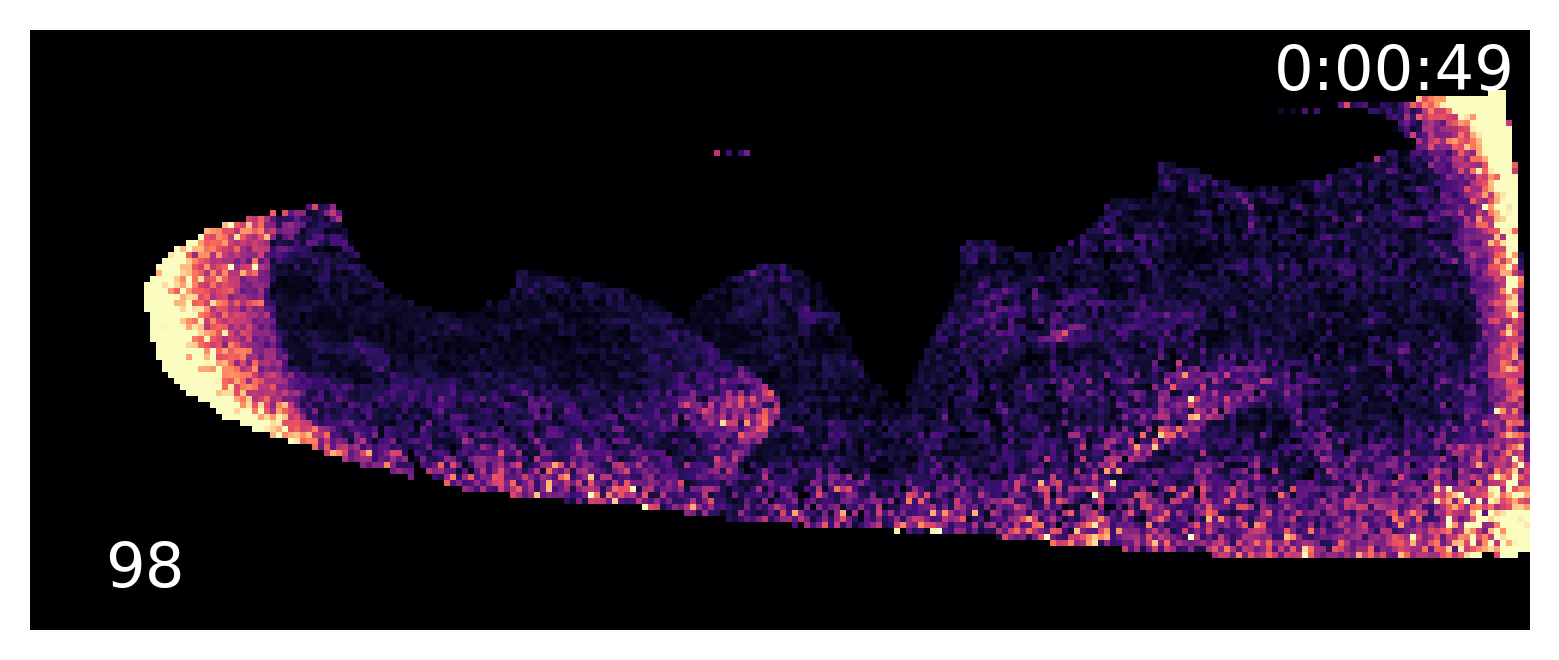

In [9]:
OUT_DIR = 'quantified_vids'
if not os.path.exists(os.path.join(PTH,OUT_DIR)):
    os.makedirs(os.path.join(PTH,OUT_DIR))

OUT_FN = 'g5ht_normalized_voxels.mp4'

frame_str = [str(i) for i in range(T)]

%matplotlib inline
anim = Microanim(
    g5_masked[np.newaxis,0:100,:,:], cmaps=['magma'], flip_map=False, fig_scaling=5, dpi=300,
    rescale_type='limits', limits=[np.percentile(g5_masked,1), np.percentile(g5_masked,99)])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')
anim.add_text_overlay(frame_str, color='white')
anim.save_movie(os.path.join(PTH,OUT_DIR,OUT_FN), quality=5, fps=6)